In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from tqdm import tqdm

!pip install pandas_profiling 
!pip install ipywidgets
from pandas_profiling import ProfileReport

In [101]:
df_A=pd.read_csv("transactions_A.csv")
df_B=pd.read_csv("transactions_B.csv")

# Base de données clients 

## On commence par constituer la base de clients sur le df_A 

In [102]:
df_base_client1 = df_A[['sender_first_name','sender_last_name','sender_birth_date']].copy()
df_base_client2 = df_A[['receiver_first_name','receiver_last_name','receiver_birth_date']].copy()

df_base_client1.head(3)

df_base_client1.drop_duplicates(keep = 'first', inplace=True)
df_base_client2.drop_duplicates(keep = 'first', inplace=True)

df_base_client1.rename(columns = {'sender_first_name': 'First_name', 'sender_last_name': 'Last_name',
                                 'sender_birth_date' : 'birth_date'},
                       inplace=True)
df_base_client2.rename(columns = {'receiver_first_name': 'First_name', 'receiver_last_name': 'Last_name',
                                 'receiver_birth_date' : 'birth_date'},
                       inplace=True)

df_base_client1.sort_values(by=['First_name', 'Last_name'],inplace=True)
df_base_client2.sort_values(by=['First_name', 'Last_name'],inplace=True)

df_base_client= pd.concat([df_base_client1,df_base_client2])
df_base_client.drop_duplicates(keep = 'first', inplace=True)
#df_base_client.head(3)

df_gpb =pd.DataFrame(df_A.groupby(by=['sender_first_name','sender_last_name','sender_birth_date'])['tx_amount'].agg(['count','mean', 'median','var']))
df_gpb.reset_index(inplace=True)
df_gpb.rename(columns = {'sender_first_name': 'First_name', 'sender_last_name': 'Last_name',
                                 'sender_birth_date' : 'birth_date',
                        'count': 'nb_tx_sent_A', 'mean': 'tx_sent_mean_A',
                        'median': 'tx_sent_med_A','var': 'variance_tx_sent_A'}, inplace=True)

df_alert =pd.DataFrame(df_A.groupby(by=['sender_first_name','sender_last_name','sender_birth_date'])['is_alert_solo'].agg(['sum']))
df_alert.reset_index(inplace=True)
df_alert.rename(columns = {'sender_first_name': 'First_name', 'sender_last_name': 'Last_name',
                                 'sender_birth_date' : 'birth_date',
                        'sum': 'nb_tx_sent_alert_solo_A'}, inplace=True)

df_base_client1.reset_index(inplace=True)
df_base_client1 = df_base_client1.drop(['index'], axis=1, inplace = False)

df_base_client1_bis = pd.merge(df_base_client1,df_gpb ,on=['First_name','Last_name','birth_date'] )
df_base_client1_ter = pd.merge(df_base_client1_bis,df_alert ,on=['First_name','Last_name','birth_date'] )

df_gpb =pd.DataFrame(df_A.groupby(by=['receiver_first_name','receiver_last_name','receiver_birth_date'])['tx_amount'].agg(['count','mean', 'median','var']))
df_gpb.reset_index(inplace=True)
df_gpb.rename(columns = {'receiver_first_name': 'First_name', 'receiver_last_name': 'Last_name',
                                 'receiver_birth_date' : 'birth_date',
                        'count': 'nb_tx_received_A', 'mean': 'tx_received_mean_A',
                        'median': 'tx_received_med_A', 'var': 'variance_tx_received_A'}, inplace=True)

df_alert =pd.DataFrame(df_A.groupby(by=['receiver_first_name','receiver_last_name','receiver_birth_date'])['is_alert_solo'].agg(['sum']))
df_alert.reset_index(inplace=True)
df_alert.rename(columns = {'receiver_first_name': 'First_name', 'receiver_last_name': 'Last_name',
                                 'receiver_birth_date' : 'birth_date',
                        'sum': 'nb_tx_received_alert_solo_A'}, inplace=True)

df_base_client2.reset_index(inplace=True)
df_base_client2 = df_base_client2.drop(['index'], axis=1, inplace = False)

df_base_client2_bis = pd.merge(df_base_client2,df_gpb ,on=['First_name','Last_name','birth_date'] )
df_base_client2_ter = pd.merge(df_base_client2_bis,df_alert ,on=['First_name','Last_name','birth_date'] )

DF_base_clients_A = pd.merge(df_base_client1_ter,df_base_client2_ter, on=['First_name','Last_name','birth_date'], how='outer')

DF_base_clients_A['nb_tx_all_A']=DF_base_clients_A.nb_tx_sent_A + DF_base_clients_A.nb_tx_received_A
DF_base_clients_A['nb_tx_alert_solo_all_A']=DF_base_clients_A.nb_tx_sent_alert_solo_A + DF_base_clients_A.nb_tx_received_alert_solo_A
#Métrique de confiance de l'individu
DF_base_clients_A['reliability_receiver_A']= 1- DF_base_clients_A['nb_tx_received_alert_solo_A']/DF_base_clients_A['nb_tx_received_A']
DF_base_clients_A['reliability_sent_A']= 1- DF_base_clients_A['nb_tx_sent_alert_solo_A']/DF_base_clients_A['nb_tx_sent_A']
DF_base_clients_A['reliability_all_A']= 1- DF_base_clients_A['nb_tx_alert_solo_all_A']/DF_base_clients_A['nb_tx_all_A']
DF_base_clients_A

,First_name,Last_name,birth_date,nb_tx_sent_A,tx_sent_mean_A,tx_sent_med_A,variance_tx_sent_A,nb_tx_sent_alert_solo_A,nb_tx_received_A,tx_received_mean_A,tx_received_med_A,variance_tx_received_A,nb_tx_received_alert_solo_A,nb_tx_all_A,nb_tx_alert_solo_all_A,reliability_receiver_A,reliability_sent_A,reliability_all_A
0,Aaron,Behrmann,1955-07-05,171.0,5.866100e+02,586.61,0.000000e+00,5.0,256.0,1.860258e+05,417.050,3.260005e+12,0.0,427.0,5.0,1.000000,0.97076,0.988290
1,Aaron,Coatney,1957-11-29,20.0,1.833900e+02,183.39,0.000000e+00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,NaN
2,Aaron,Davis,1947-09-15,169.0,4.379800e+02,437.98,0.000000e+00,0.0,51.0,1.088556e+06,215.750,1.817869e+13,1.0,220.0,1.0,0.980392,1.00000,0.995455
3,Aaron,Gaskin,1942-04-25,19.0,1.285646e+06,114574.16,3.509760e+12,0.0,36.0,4.306681e+05,109.500,6.575276e+12,0.0,55.0,0.0,1.000000,1.00000,1.000000
4,Aaron,Lykins,1964-11-06,20.0,2.866700e+02,286.67,0.000000e+00,0.0,38.0,1.705050e+02,170.505,7.534191e+01,0.0,58.0,0.0,1.000000,1.00000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9772,William,Tucker,1925-10-31,NaN,NaN,NaN,NaN,NaN,44.0,3.277345e+05,164.070,2.469403e+12,0.0,NaN,NaN,1.000000,NaN,NaN
9773,Willis,Saunders,1945-09-06,NaN,NaN,NaN,NaN,NaN,188.0,4.963039e+02,535.530,1.922591e+04,0.0,NaN,NaN,1.000000,NaN,NaN
9774,Ying,Blackmon,1987-02-28,NaN,NaN,NaN,NaN,NaN,19.0,1.349700e+02,134.970,0.000000e+00,0.0,NaN,NaN,1.000000,NaN,NaN
9775,Yvonne,Howard,1939-07-16,NaN,NaN,NaN,NaN,NaN,55.0,1.129082e+02,147.660,4.009877e+03,0.0,NaN,NaN,1.000000,NaN,NaN


## On fait la même chose pour B 

In [103]:
"On fait la même chose pour df_B"

df_base_client1 = df_B[['sender_first_name','sender_last_name','sender_birth_date']].copy()
df_base_client2 = df_B[['receiver_first_name','receiver_last_name','receiver_birth_date']].copy()

df_base_client1.head(3)

df_base_client1.drop_duplicates(keep = 'first', inplace=True)
df_base_client2.drop_duplicates(keep = 'first', inplace=True)

df_base_client1.rename(columns = {'sender_first_name': 'First_name', 'sender_last_name': 'Last_name',
                                 'sender_birth_date' : 'birth_date'},
                       inplace=True)
df_base_client2.rename(columns = {'receiver_first_name': 'First_name', 'receiver_last_name': 'Last_name',
                                 'receiver_birth_date' : 'birth_date'},
                       inplace=True)

df_base_client1.sort_values(by=['First_name', 'Last_name'],inplace=True)
df_base_client2.sort_values(by=['First_name', 'Last_name'],inplace=True)

df_base_client= pd.concat([df_base_client1,df_base_client2])
df_base_client.drop_duplicates(keep = 'first', inplace=True)

df_gpb =pd.DataFrame(df_B.groupby(by=['sender_first_name','sender_last_name','sender_birth_date'])['tx_amount'].agg(['count','mean', 'median','var']))
df_gpb.reset_index(inplace=True)
df_gpb.rename(columns = {'sender_first_name': 'First_name', 'sender_last_name': 'Last_name',
                                 'sender_birth_date' : 'birth_date',
                        'count': 'nb_tx_sent_B', 'mean': 'tx_sent_mean_B',
                        'median': 'tx_sent_med_B', 'var': 'variance_tx_sent_B'}, inplace=True)

df_alert =pd.DataFrame(df_B.groupby(by=['sender_first_name','sender_last_name','sender_birth_date'])['is_alert_solo'].agg(['sum']))
df_alert.reset_index(inplace=True)
df_alert.rename(columns = {'sender_first_name': 'First_name', 'sender_last_name': 'Last_name',
                                 'sender_birth_date' : 'birth_date',
                        'sum': 'nb_tx_sent_alert_solo_B'}, inplace=True)

df_base_client1.reset_index(inplace=True)
df_base_client1 = df_base_client1.drop(['index'], axis=1, inplace = False)

df_base_client1_bis = pd.merge(df_base_client1,df_gpb ,on=['First_name','Last_name','birth_date'] )
df_base_client1_ter = pd.merge(df_base_client1_bis,df_alert ,on=['First_name','Last_name','birth_date'] )

df_gpb =pd.DataFrame(df_B.groupby(by=['receiver_first_name','receiver_last_name','receiver_birth_date'])['tx_amount'].agg(['count','mean', 'median','var']))
df_gpb.reset_index(inplace=True)
df_gpb.rename(columns = {'receiver_first_name': 'First_name', 'receiver_last_name': 'Last_name',
                                 'receiver_birth_date' : 'birth_date',
                        'count': 'nb_tx_received_B', 'mean': 'tx_received_mean_B',
                        'median': 'tx_received_med_B', 'var': 'variance_tx_received_B'}, inplace=True)

df_alert =pd.DataFrame(df_B.groupby(by=['receiver_first_name','receiver_last_name','receiver_birth_date'])['is_alert_solo'].agg(['sum']))
df_alert.reset_index(inplace=True)
df_alert.rename(columns = {'receiver_first_name': 'First_name', 'receiver_last_name': 'Last_name',
                                 'receiver_birth_date' : 'birth_date',
                        'sum': 'nb_tx_received_alert_solo_B'}, inplace=True)

df_base_client2.reset_index(inplace=True)
df_base_client2 = df_base_client2.drop(['index'], axis=1, inplace = False)

df_base_client2_bis = pd.merge(df_base_client2,df_gpb ,on=['First_name','Last_name','birth_date'] )
df_base_client2_ter = pd.merge(df_base_client2_bis,df_alert ,on=['First_name','Last_name','birth_date'] )

DF_base_clients_B = pd.merge(df_base_client1_ter,df_base_client2_ter, on=['First_name','Last_name','birth_date'], how='outer')

DF_base_clients_B['nb_tx_all_B']=DF_base_clients_B.nb_tx_sent_B + DF_base_clients_B.nb_tx_received_B
DF_base_clients_B['nb_tx_alert_solo_all_B']=DF_base_clients_B.nb_tx_sent_alert_solo_B + DF_base_clients_B.nb_tx_received_alert_solo_B
#Métrique de confiance de l'individu
DF_base_clients_B['reliability_receiver_B']= 1- DF_base_clients_B['nb_tx_received_alert_solo_B']/DF_base_clients_B['nb_tx_received_B']
DF_base_clients_B['reliability_sent_B']= 1- DF_base_clients_B['nb_tx_sent_alert_solo_B']/DF_base_clients_B['nb_tx_sent_B']
DF_base_clients_B['reliability_all_B']= 1- DF_base_clients_B['nb_tx_alert_solo_all_B']/DF_base_clients_B['nb_tx_all_B']
DF_base_clients_B

,First_name,Last_name,birth_date,nb_tx_sent_B,tx_sent_mean_B,tx_sent_med_B,variance_tx_sent_B,nb_tx_sent_alert_solo_B,nb_tx_received_B,tx_received_mean_B,tx_received_med_B,variance_tx_received_B,nb_tx_received_alert_solo_B,nb_tx_all_B,nb_tx_alert_solo_all_B,reliability_receiver_B,reliability_sent_B,reliability_all_B
0,Aaron,Coatney,1957-11-29,174.0,1.833900e+02,183.390,0.000000e+00,1.0,86.0,3.359641e+05,36.35,5.957497e+12,0.0,260.0,1.0,1.0,0.994253,0.996154
1,Aaron,Gaskin,1942-04-25,6.0,1.233644e+06,71893.455,3.420208e+12,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
2,Aaron,Grubb,1962-02-23,20.0,1.276800e+02,127.680,0.000000e+00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
3,Aaron,Martinez,1941-05-16,169.0,4.959500e+02,495.950,0.000000e+00,0.0,24.0,1.904959e+06,143.66,2.991695e+13,0.0,193.0,0.0,1.0,1.000000,1.000000
4,Aaron,Rash,1967-03-21,15.0,1.783502e+06,213834.570,1.352206e+13,0.0,64.0,3.588018e+05,19.05,2.782158e+12,0.0,79.0,0.0,1.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,Yuk,Kliebert,1945-12-20,NaN,NaN,NaN,NaN,NaN,16.0,9.742463e+02,16.04,1.469055e+07,0.0,NaN,NaN,1.0,NaN,NaN
8757,Yvonne,Crawford,1973-04-16,NaN,NaN,NaN,NaN,NaN,4.0,9.682648e+06,8565027.81,1.130437e+14,0.0,NaN,NaN,1.0,NaN,NaN
8758,Yvonne,Westley,1941-04-15,NaN,NaN,NaN,NaN,NaN,57.0,1.255012e+02,174.49,6.296854e+03,0.0,NaN,NaN,1.0,NaN,NaN
8759,Zonia,Bucci,1955-11-23,NaN,NaN,NaN,NaN,NaN,19.0,1.602500e+02,160.25,0.000000e+00,0.0,NaN,NaN,1.0,NaN,NaN


# Partie : Modélisation 

# I- Enrichissement du dataset (par l'intermédiaire de la base de données clients) 

Dans un premier temps, on va réaliser la modélisation avec le df_merge grâce aux tx_id. 
Ensuite on fera exactement la même chose mais avec le df_merge grâce au pooling. 


In [104]:
df_A=pd.read_csv("transactions_A.csv")
df_B=pd.read_csv("transactions_B.csv")

## Question principale : que va apporter les informations de B à A ?

On analyse premièrement quelles informations supplémentaires obtient-on grâce aux 2 lignes. 
Pour cela, on récupère les tx_id présentes dans les 2 datasets et on regarde les 2 lignes correspondantes. 

In [105]:
# On accède à toutes les tx_id présentes dans les deux df
L1 = list(df_A['tx_id'].values) 
L2 = list(df_B['tx_id'].values)

L=np.isin(L1,L2).astype(int)*L1
L=L[L != 0]  #liste des transactions appartenant aux 2 datasets 

In [106]:
def analyse_de_tx(nb_tx):
    "permet de comparer deux lignes d'une même transaction"
    display(df_A[df_A['tx_id']==nb_tx])
    display(df_B[df_B['tx_id']==nb_tx])

In [107]:
analyse_de_tx(L[145667])

,tx_id,sender_account_id,receiver_account_id,tx_amount,timestamp,tx_type,sender_bank_id,sender_first_name,sender_last_name,sender_country_code,sender_birth_date,sender_zip_code,receiver_bank_id,receiver_first_name,receiver_last_name,receiver_country_code,receiver_birth_date,receiver_zip_code,is_alert_solo,is_alert_pooled
573954,905797,NaN,1822.0,511.05,2020-10-17,WIRE,B,Scott,Lawler,FR,1938-09-17,68740,A,Ambrose,Cole,FR,1958-04-07,3800,False,False


,tx_id,sender_account_id,receiver_account_id,tx_amount,timestamp,tx_type,sender_bank_id,sender_first_name,sender_last_name,sender_country_code,sender_birth_date,sender_zip_code,receiver_bank_id,receiver_first_name,receiver_last_name,receiver_country_code,receiver_birth_date,receiver_zip_code,is_alert_solo,is_alert_pooled
314875,905797,4585.0,NaN,511.05,2020-10-17,WIRE,B,Scott,Lawler,FR,1938-09-17,68740,A,Ambrose,Cole,FR,1958-04-07,3800,False,False


Les 2 lignes sont équivalentes pour la plupart (totalité?) des transactions en commun. 
La seule différence est le sender_account_id ou le receiver_account_id qui n'ont pas réellement d'importance. 


#### ==> Une hypothèse que l'on peut formuler à ce stade est que la plus-value de merge les DF porte donc sur les clients ! 

## On va ajouter les informations clients (des deux bases de données A et B) au dataframe pour compléter notre dataset ! 

In [108]:
"On s'occupe du sender"

#Informations obtenue avec base clients A
df_A_bis =pd.merge(df_A, DF_base_clients_A[['First_name','Last_name','birth_date','nb_tx_sent_A','tx_sent_mean_A','tx_sent_med_A',
                                        'nb_tx_sent_alert_solo_A','nb_tx_all_A', 'nb_tx_alert_solo_all_A']]
               , left_on =['sender_first_name','sender_last_name','sender_birth_date']
               ,right_on =['First_name','Last_name','birth_date'], how='left').drop(['First_name','Last_name','birth_date'], axis=1)

#Informations obtenue avec base clients B
df_A_bis =pd.merge(df_A_bis, DF_base_clients_B[['First_name','Last_name','birth_date','nb_tx_sent_B','tx_sent_mean_B','tx_sent_med_B',
                                        'nb_tx_sent_alert_solo_B', 'nb_tx_all_B', 'nb_tx_alert_solo_all_B']]
               , left_on =['sender_first_name','sender_last_name','sender_birth_date']
               ,right_on =['First_name','Last_name','birth_date'], how='left').drop(['First_name','Last_name','birth_date'], axis=1)

"On s'occupe du receiver"

#Informations obtenue avec base clients A
df_A_bis =pd.merge(df_A_bis, DF_base_clients_A[['First_name','Last_name','birth_date','nb_tx_received_A', 'tx_received_mean_A'
                                                ,'tx_received_med_A','nb_tx_received_alert_solo_A', 'nb_tx_all_A'
                                                , 'nb_tx_alert_solo_all_A']]
               , left_on =['receiver_first_name','receiver_last_name','receiver_birth_date']
               ,right_on =['First_name','Last_name','birth_date']
            ,suffixes=('_sender','_receiver'), how='left'
              ).drop(['First_name','Last_name','birth_date'], axis=1)

#Informations obtenue avec base clients B
df_A_bis =pd.merge(df_A_bis, DF_base_clients_B[['First_name','Last_name','birth_date','nb_tx_received_B', 'tx_received_mean_B'
                                                ,'tx_received_med_B','nb_tx_received_alert_solo_B', 'nb_tx_all_B'
                                                , 'nb_tx_alert_solo_all_B']]
               , left_on =['receiver_first_name','receiver_last_name','receiver_birth_date']
               ,right_on =['First_name','Last_name','birth_date']
              ,suffixes=('_sender','_receiver'), how='left').drop(['First_name','Last_name','birth_date'], axis=1)



df_A_bis.drop(['sender_account_id','receiver_account_id'], inplace=True, axis=1)
df_A_bis.head(5)

,tx_id,tx_amount,timestamp,tx_type,sender_bank_id,sender_first_name,sender_last_name,sender_country_code,sender_birth_date,sender_zip_code,...,tx_received_med_A,nb_tx_received_alert_solo_A,nb_tx_all_A_receiver,nb_tx_alert_solo_all_A_receiver,nb_tx_received_B,tx_received_mean_B,tx_received_med_B,nb_tx_received_alert_solo_B,nb_tx_all_B_receiver,nb_tx_alert_solo_all_B_receiver
0,3109,229.97,2018-03-03,WIRE,A,Marie,Lee,FR,1937-08-23,27800,...,418.89,6.0,479.0,9.0,251.0,383.468008,503.44,1.0,365.0,1.0
1,1829,117.83,2018-03-03,WIRE,B,Kurt,Brignac,FR,1962-09-07,35660,...,22.08,0.0,528.0,0.0,64.0,94.762500,117.83,0.0,150.0,1.0
2,1830,117.83,2018-03-03,WIRE,B,Kurt,Brignac,FR,1962-09-07,35660,...,67.35,0.0,274.0,0.0,20.0,117.830000,117.83,0.0,82.0,0.0
3,1831,526.02,2018-03-03,WIRE,C,Shelly,Jethva,CN,1961-06-29,65230,...,511.05,0.0,754.0,0.0,371.0,2913.308140,511.05,2.0,386.0,2.0
4,1832,35.79,2018-03-03,WIRE,A,Judy,James,FR,1942-04-08,42140,...,20.37,0.0,57.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


### On crée une métrique : fiabilité de l'individu qui vaut 1 si l'individu n'a jamais eu alert_solo

In [109]:
#Receiver
df_A_bis['reliability_receiver_A']= 1- df_A_bis['nb_tx_received_alert_solo_A']/df_A_bis['nb_tx_received_A']
df_A_bis['reliability_receiver_B']= 1- df_A_bis['nb_tx_received_alert_solo_B']/df_A_bis['nb_tx_received_B']

#Sender
df_A_bis['reliability_sender_A']= 1- df_A_bis['nb_tx_sent_alert_solo_A']/df_A_bis['nb_tx_sent_A']
df_A_bis['reliability_sender_B']= 1- df_A_bis['nb_tx_sent_alert_solo_B']/df_A_bis['nb_tx_sent_B']

In [110]:
df_merge= pd.merge(df_A_bis, df_B[['tx_id','is_alert_solo', 'is_alert_pooled']], on = ['tx_id'], how='inner', suffixes=('_A','_B'))
df_merge.drop(['is_alert_pooled_A'], axis=1, inplace=True)
df_merge.rename(columns = {'is_alert_pooled_B': 'is_alert_pooled'}, inplace=True)

display(df_merge.head(2))  
df_merge.columns

,tx_id,tx_amount,timestamp,tx_type,sender_bank_id,sender_first_name,sender_last_name,sender_country_code,sender_birth_date,sender_zip_code,...,tx_received_med_B,nb_tx_received_alert_solo_B,nb_tx_all_B_receiver,nb_tx_alert_solo_all_B_receiver,reliability_receiver_A,reliability_receiver_B,reliability_sender_A,reliability_sender_B,is_alert_solo_B,is_alert_pooled
0,1829,117.83,2018-03-03,WIRE,B,Kurt,Brignac,FR,1962-09-07,35660,...,117.83,0.0,150.0,1.0,1.0,1.0,0.983193,1.0,False,False
1,1830,117.83,2018-03-03,WIRE,B,Kurt,Brignac,FR,1962-09-07,35660,...,117.83,0.0,82.0,0.0,1.0,1.0,0.983193,1.0,False,False


Index(['tx_id', 'tx_amount', 'timestamp', 'tx_type', 'sender_bank_id',
       'sender_first_name', 'sender_last_name', 'sender_country_code',
       'sender_birth_date', 'sender_zip_code', 'receiver_bank_id',
       'receiver_first_name', 'receiver_last_name', 'receiver_country_code',
       'receiver_birth_date', 'receiver_zip_code', 'is_alert_solo_A',
       'nb_tx_sent_A', 'tx_sent_mean_A', 'tx_sent_med_A',
       'nb_tx_sent_alert_solo_A', 'nb_tx_all_A_sender',
       'nb_tx_alert_solo_all_A_sender', 'nb_tx_sent_B', 'tx_sent_mean_B',
       'tx_sent_med_B', 'nb_tx_sent_alert_solo_B', 'nb_tx_all_B_sender',
       'nb_tx_alert_solo_all_B_sender', 'nb_tx_received_A',
       'tx_received_mean_A', 'tx_received_med_A',
       'nb_tx_received_alert_solo_A', 'nb_tx_all_A_receiver',
       'nb_tx_alert_solo_all_A_receiver', 'nb_tx_received_B',
       'tx_received_mean_B', 'tx_received_med_B',
       'nb_tx_received_alert_solo_B', 'nb_tx_all_B_receiver',
       'nb_tx_alert_solo_all_B_receiv

### On met les dates en datetime 

In [122]:
df_merge['timestamp'] = pd.to_datetime(df_merge.timestamp, format='%Y-%m-%d', errors = 'ignore')
df_merge['sender_birth_date'] = pd.to_datetime(df_merge.sender_birth_date, format='%Y-%m-%d', errors = 'ignore')
df_merge['receiver_birth_date'] = pd.to_datetime(df_merge.receiver_birth_date, format='%Y-%m-%d', errors = 'ignore')

#### On crée également des nouvelles features : 
- écart en % de tx_amount par rapport à la médiane de tx_amount pour un client 
- jour de l'année/ jour du mois 

In [124]:
#Écart
df_merge['ecarts_tx_received_A']= (df_merge.tx_amount - df_merge.tx_received_med_A)/df_merge.tx_received_med_A*100
df_merge['ecarts_tx_received_B']= (df_merge.tx_amount - df_merge.tx_received_med_B)/df_merge.tx_received_med_B*100
df_merge['ecarts_tx_sent_A']= (df_merge.tx_amount - df_merge.tx_sent_med_A)/df_merge.tx_sent_med_A*100
df_merge['ecarts_tx_sent_B']= (df_merge.tx_amount - df_merge.tx_sent_med_B)/df_merge.tx_sent_med_B*100

#Jours de l'année/du mois 
df_merge['jour_année_tx']=df_merge['timestamp'].dt.dayofyear
df_merge['jour_mois_tx']= df_merge['timestamp'].dt.day

#Mois et année
df_merge['année_tx']=df_merge['timestamp'].dt.year
df_merge['mois_tx']=df_merge['timestamp'].dt.month

df_merge.head(5)

,tx_id,tx_amount,timestamp,tx_type,sender_bank_id,sender_first_name,sender_last_name,sender_country_code,sender_birth_date,sender_zip_code,...,is_alert_solo_B,is_alert_pooled,ecarts_tx_received_A,ecarts_tx_received_B,ecarts_tx_sent_A,ecarts_tx_sent_B,jour_année_tx,jour_mois_tx,année_tx,mois_tx
0,1829,117.83,2018-03-03,WIRE,B,Kurt,Brignac,FR,1962-09-07,35660,...,False,False,433.650362,0.000000,0.0,0.0,62,3,2018,3
1,1830,117.83,2018-03-03,WIRE,B,Kurt,Brignac,FR,1962-09-07,35660,...,False,False,74.951745,0.000000,0.0,0.0,62,3,2018,3
2,1838,21.21,2018-03-03,WIRE,A,Gabrielle,Evans,FR,1958-04-17,54200,...,True,False,-77.593492,-79.629274,0.0,0.0,62,3,2018,3
3,2735,168.11,2018-03-03,WIRE,A,Billy,Dozier,FR,1929-09-13,76460,...,False,False,77.593492,61.457933,0.0,NaN,62,3,2018,3
4,3351,134.86,2018-03-03,WIRE,B,Myong,Byrd,FR,1918-05-14,61150,...,False,False,-26.261687,-1.324358,0.0,0.0,62,3,2018,3


In [113]:
# Il y a des cas étranges comme K*** Brig***

#df_merge[(df_merge['sender_first_name']=='K***')&(df_merge['sender_last_name']=='Brig***')]

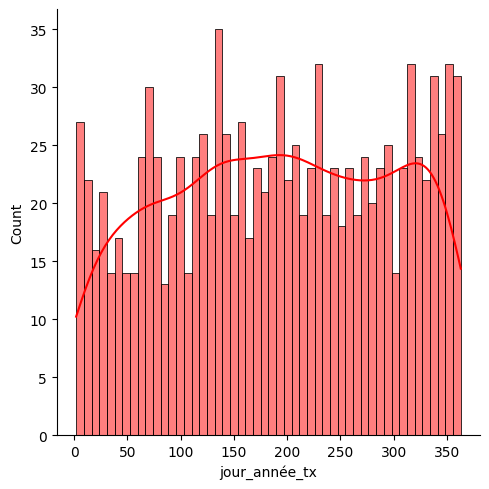

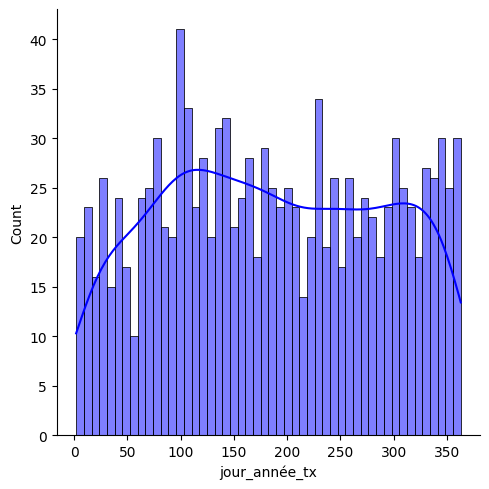

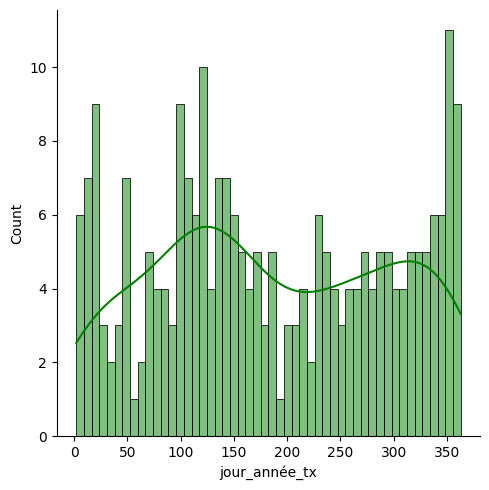

In [114]:
#On regarde dans de manière naïve si le jour de l'année semble avoir un rôle à jouer dans le fait d'être alert ou pas 

sns.displot(df_merge[df_merge['is_alert_solo_A']==1]['jour_année_tx'], kde= True, color='red', bins=50)
sns.displot(df_merge[df_merge['is_alert_solo_B']==1]['jour_année_tx'], kde= True, color='blue', bins=50)
sns.displot(df_merge[df_merge['is_alert_pooled']==1]['jour_année_tx'], kde= True, color='green', bins=50)

##### ==> On observe que de nombreuses tx pooled sont alertées en période de fin d'année Noël et Jour de l'an
==> On peut penser notamment aux cadeaux et aux étrennes

- cela permet de justifier la feature jour de l'année

In [125]:
df_merge.columns

Index(['tx_id', 'tx_amount', 'timestamp', 'tx_type', 'sender_bank_id',
       'sender_first_name', 'sender_last_name', 'sender_country_code',
       'sender_birth_date', 'sender_zip_code', 'receiver_bank_id',
       'receiver_first_name', 'receiver_last_name', 'receiver_country_code',
       'receiver_birth_date', 'receiver_zip_code', 'is_alert_solo_A',
       'nb_tx_sent_A', 'tx_sent_mean_A', 'tx_sent_med_A',
       'nb_tx_sent_alert_solo_A', 'nb_tx_all_A_sender',
       'nb_tx_alert_solo_all_A_sender', 'nb_tx_sent_B', 'tx_sent_mean_B',
       'tx_sent_med_B', 'nb_tx_sent_alert_solo_B', 'nb_tx_all_B_sender',
       'nb_tx_alert_solo_all_B_sender', 'nb_tx_received_A',
       'tx_received_mean_A', 'tx_received_med_A',
       'nb_tx_received_alert_solo_A', 'nb_tx_all_A_receiver',
       'nb_tx_alert_solo_all_A_receiver', 'nb_tx_received_B',
       'tx_received_mean_B', 'tx_received_med_B',
       'nb_tx_received_alert_solo_B', 'nb_tx_all_B_receiver',
       'nb_tx_alert_solo_all_B_receiv

### Sélection des variables 
Voici les variables que l'on enlève dans un premier temps (on les rajoutera peut être après (si on perd trop d'infos (BVO))). 
Plusieurs raisons possible pour la suppression : 
- inutiles pour la prédiction : 
`sender_bank_id`, `receiver_bank_id`, `sender_zip_code`, `receiver_zip_code`, `tx_id` 
- des variables qu'on peut retrouver grâce aux autres (écarts_tx et tx_amount)
 `tx_sent_med_A`,`tx_sent_med_B`, `tx_received_med_A`, `tx_received_med_B`,
- d'autres variables qu'on peut retrouver grâce aux autres (reliability et nb_tx)
`nb_tx_sent_alert_solo_A`,`nb_tx_sent_alert_solo_B`
`nb_tx_received_alert_solo_A`,`nb_tx_received_alert_solo_B`, `timestamp`

In [466]:
df_merge_bis=df_merge[['tx_amount', 'tx_type',
                       'jour_année_tx', 'jour_mois_tx', 'année_tx', 'mois_tx',
                       
       #'sender_first_name', 'sender_last_name', 'sender_country_code','sender_birth_date',
       #'receiver_first_name', 'receiver_last_name', 'receiver_country_code','receiver_birth_date',
                       
       'tx_sent_mean_A','tx_sent_mean_B','tx_received_mean_A','tx_received_mean_B',
                       
       'nb_tx_sent_A', 'nb_tx_all_A_sender',
       'nb_tx_sent_B', 'nb_tx_all_B_sender',
                       
       'nb_tx_received_A','nb_tx_all_A_receiver',
       'nb_tx_received_B','nb_tx_all_B_receiver',
                       
       'nb_tx_alert_solo_all_A_sender', 'nb_tx_alert_solo_all_B_sender',
       'nb_tx_alert_solo_all_A_receiver','nb_tx_alert_solo_all_B_receiver',
                       
       'reliability_receiver_A','reliability_receiver_B', 
       'reliability_sender_A','reliability_sender_B',
                       
       'ecarts_tx_received_A', 'ecarts_tx_received_B', 
       'ecarts_tx_sent_A','ecarts_tx_sent_B',  
                       
       #'is_alert_solo_A','is_alert_solo_B',
       'is_alert_pooled']].copy()

# Modélisation  

## Preprocessing

In [467]:
import sklearn

In [468]:
#from sklearn.preprocessing import OneHotEncoder
#encoder = sklearn.preprocessing.OneHotEncoder

In [469]:
#Variable catégorielle tx_type

tx_type_ = pd.get_dummies(df_merge_bis['tx_type'],drop_first=True)
df_merge_bis= pd.concat([df_merge_bis, tx_type_], axis=1)
df_merge_bis.drop(['tx_type'],axis=1,inplace=True)
df_merge_bis.rename(columns={'WIRE': 'tx_type', 
                           }, inplace=True)
df_merge_bis.head(3)

,tx_amount,jour_année_tx,jour_mois_tx,année_tx,mois_tx,tx_sent_mean_A,tx_sent_mean_B,tx_received_mean_A,tx_received_mean_B,nb_tx_sent_A,...,reliability_receiver_A,reliability_receiver_B,reliability_sender_A,reliability_sender_B,ecarts_tx_received_A,ecarts_tx_received_B,ecarts_tx_sent_A,ecarts_tx_sent_B,is_alert_pooled,tx_type
0,117.83,62,3,2018,3,117.830000,117.830000,72283.647706,94.762500,119.0,...,1.000,1.000000,0.983193,1.000000,433.650362,0.000000,0.0,0.0,False,1
1,117.83,62,3,2018,3,117.830000,117.830000,344771.070111,117.830000,119.0,...,1.000,1.000000,0.983193,1.000000,74.951745,0.000000,0.0,0.0,False,1
2,21.21,62,3,2018,3,21.175068,21.089767,94.660000,94.993301,148.0,...,0.975,0.961165,0.979730,0.906977,-77.593492,-79.629274,0.0,0.0,False,1


In [470]:
#df_merge_bis['is_alert_solo_A']= df_merge_bis['is_alert_solo_A'].apply( lambda x : int(x))
#df_merge_bis['is_alert_solo_B']= df_merge_bis['is_alert_solo_B'].apply( lambda x : int(x))
df_merge_bis['is_alert_pooled']= df_merge_bis['is_alert_pooled'].apply( lambda x : int(x))

In [471]:
df_merge_bis.dtypes

tx_amount                          float64
jour_année_tx                        int64
jour_mois_tx                         int64
année_tx                             int64
mois_tx                              int64
tx_sent_mean_A                     float64
tx_sent_mean_B                     float64
tx_received_mean_A                 float64
tx_received_mean_B                 float64
nb_tx_sent_A                       float64
nb_tx_all_A_sender                 float64
nb_tx_sent_B                       float64
nb_tx_all_B_sender                 float64
nb_tx_received_A                   float64
nb_tx_all_A_receiver               float64
nb_tx_received_B                   float64
nb_tx_all_B_receiver               float64
nb_tx_alert_solo_all_A_sender      float64
nb_tx_alert_solo_all_B_sender      float64
nb_tx_alert_solo_all_A_receiver    float64
nb_tx_alert_solo_all_B_receiver    float64
reliability_receiver_A             float64
reliability_receiver_B             float64
reliability

In [472]:
df_4= df_merge_bis.copy()
df_4.dropna(inplace=True)

In [481]:
print("taille totale "+str(len(df_4)/len(df_merge_bis)*100))
print("part des is_alert_pooled "+str((df_4['is_alert_pooled'].sum())/(df_merge_bis['is_alert_pooled'].sum())*100))

taille totale 62.008756213290454
part des is_alert_pooled 64.77732793522267


### Première approche : on drop les NaNs

## Standardisation

In [474]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

`RobustScaler` est insensible aux outliers 
On note IQR : l'écart interquartile (Q3 -Q1) 
On a : 

$$ X_{scaled}=\frac{X - médiane}{IQR} $$

Et la médiane est beaucoup moins sensible aux outliers

In [475]:
X=df_4.drop(['is_alert_pooled'],axis=1)
y= df_4['is_alert_pooled']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1 )

X_t=X_train.copy() #on utilisera cela plus tard pour l'importance des coefficients (X_t ne sera pas standardisé contrairement à X_train)

In [476]:
scaler=RobustScaler()
    
X_train = scaler.fit_transform(X_train) #fit_transform is a easy way to do the following normally 
X_test= scaler.transform(X_test)

In [477]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13174
           1       1.00      0.92      0.96        13

    accuracy                           1.00     13187
   macro avg       1.00      0.96      0.98     13187
weighted avg       1.00      1.00      1.00     13187

[[13174     0]
 [    1    12]]


<AxesSubplot:>

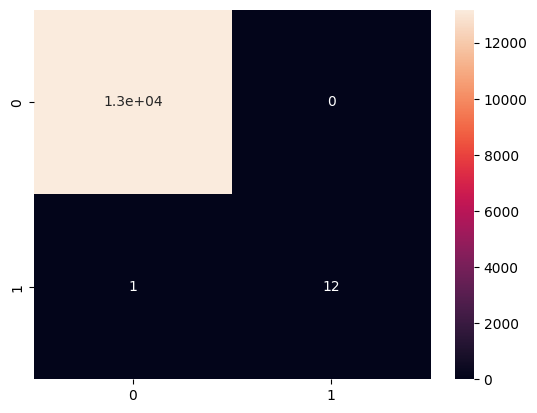

In [478]:
model = RandomForestClassifier(n_estimators=30, max_depth=10) #LogisticRegression()
model.fit(X_train, y_train) 

predictions= model.predict(X_test)

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
sns.heatmap(confusion_matrix(y_test,predictions),annot=True)

In [479]:
y_test.sum()

13

In [435]:
#Reg logistique 

#coefs = pd.DataFrame(
#   model.coef_[0],
#   columns=['Coefficients'], index=X_t.columns)
#coefs.sort_values(by='Coefficients', ascending=True, inplace=True)
#coefs.plot(kind='barh', figsize=(7, 7), color='royalblue')
#plt.title('Regression_logistique')
#plt.axvline(x=0, color='1')
#plt.grid()
#plt.subplots_adjust(left=.3)

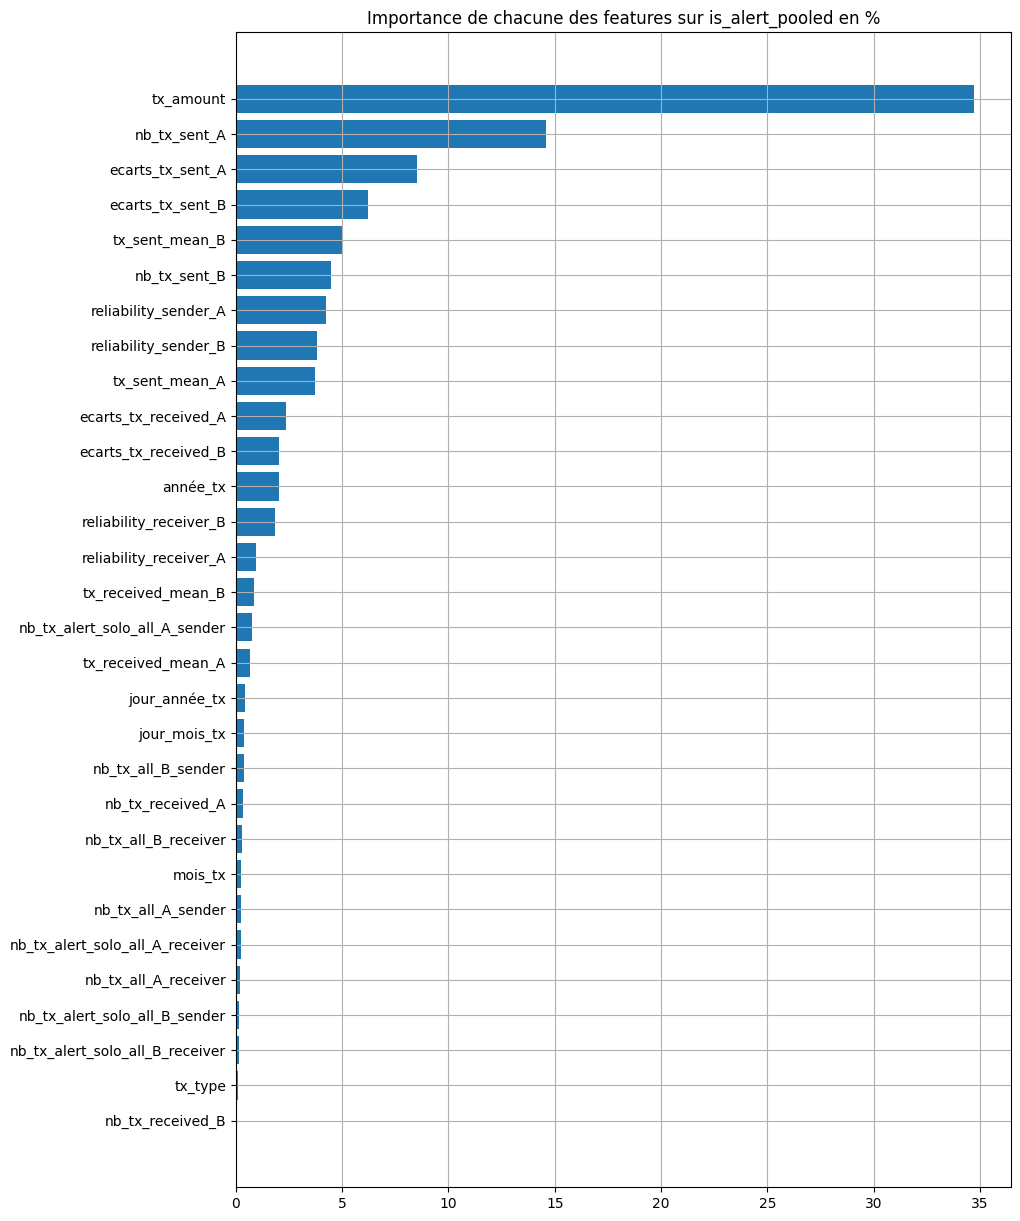

In [480]:
#RFClassifier
importances = model.feature_importances_

indices = np.argsort(importances)


fig, ax = plt.subplots(figsize=(10,15))
ax.barh(range(len(importances)), importances[indices]*100)
ax.set_yticks(range(len(importances)), colors='royalblue')
_ = ax.set_yticklabels(np.array(X_t.columns)[indices])
plt.grid()
plt.title("Importance de chacune des features sur is_alert_pooled en %")
plt.show()

In [423]:
from sklearn.model_selection import GridSearchCV

In [397]:
parameters = {
    'n_estimators': [ 20, 30,40,50,100],
    'max_depth': [5,6,10,12],
}
regr = RandomForestClassifier()

grid = GridSearchCV(regr, parameters)
grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 6, 10, 12],
                         'n_estimators': [20, 30, 40, 50, 100]})

In [398]:
grid.best_params_

{'max_depth': 12, 'n_estimators': 40}

In [399]:
model=grid.best_estimator_
model.score(X_test, y_test)

0.999848335481914

In [400]:
model.fit(X_train, y_train) 
predictions= model.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13176
           1       1.00      0.82      0.90        11

    accuracy                           1.00     13187
   macro avg       1.00      0.91      0.95     13187
weighted avg       1.00      1.00      1.00     13187

[[13176     0]
 [    2     9]]


<AxesSubplot:>

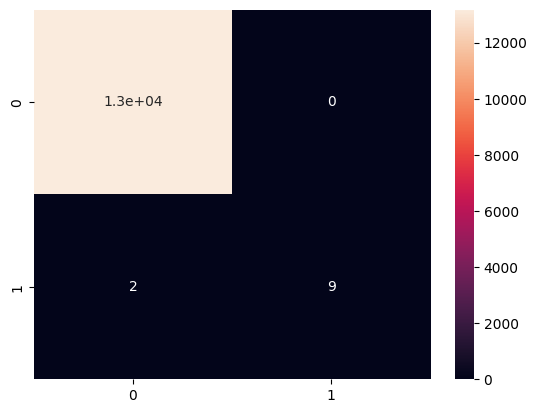

In [401]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
sns.heatmap(confusion_matrix(y_test,predictions),annot=True)